# AI Image Search with Multimodal Embeddings

## Learning Objectives

**Embeddings** are a way to represent the meaning of texts, images, or information as a list of numbers. Using a simple comparison function, we can calculate a similarity score for two embeddings to figure out whether two pieces of information are about similar things.

Common use-cases for embeddings include:
- **Semantic search**: Finding relevant content using natural language
- **Clustering**: Grouping similar items together
- **Classification**: Categorizing content automatically

This notebook demonstrates how to:
1. Generate embeddings for images using Cohere's `embed-v4.0` multimodal model
2. Generate embeddings for text queries
3. Compare them using cosine similarity
4. Build a practical image search engine

---

## Overview

This notebook demonstrates **multimodal embeddings** for AI-powered image search:

**What you'll learn:**
- How embeddings represent images and text as numerical vectors
- Computing similarity between images and text queries
- Building a practical image search engine

**What you'll do:**
1. Load images (2 default SJSU images OR your own folder)
2. Generate embeddings with available providers (Cohere, OpenAI, or both)
3. Analyze image-to-image and text-to-image similarities
4. Search interactively with any text query

---

### Setup and Dependencies

In [1]:
import os
import base64
import glob
import requests
import numpy as np
from dotenv import load_dotenv
from PIL import Image
import cohere
from openai import OpenAI
from IPython.display import display, HTML, Image as IPImage

# Load API keys from .env file
load_dotenv()
COHERE_API_KEY = os.getenv('COHERE_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Track available providers
PROVIDERS = {}

if COHERE_API_KEY:
    PROVIDERS['Cohere'] = cohere.ClientV2(api_key=COHERE_API_KEY)
    print("✓ Cohere API key loaded")
else:
    print("⚠️  COHERE_API_KEY not found")

if OPENAI_API_KEY:
    PROVIDERS['OpenAI'] = OpenAI(api_key=OPENAI_API_KEY)
    print("✓ OpenAI API key loaded")
else:
    print("⚠️  OPENAI_API_KEY not found")

if not PROVIDERS:
    print("\n❌ No API keys found! Please add keys to .env file")
    print("Get keys from:")
    print("  - Cohere: https://dashboard.cohere.com/api-keys")
    print("  - OpenAI: https://platform.openai.com/api-keys")
else:
    provider_names = ", ".join(PROVIDERS.keys())
    print(f"\n✓ {len(PROVIDERS)} provider(s) initialized: {provider_names}")

/Users/banbalagan/Projects/ai_image_search/ai_image_search_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✓ Cohere API key loaded
✓ OpenAI API key loaded

✓ 2 provider(s) initialized: Cohere, OpenAI


### Helper Functions

In [2]:
def download_image(url):
    """Download image from URL and return binary content."""
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return response.content
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None

def image_to_base64(image_bytes):
    """Convert image bytes to base64 data URI for API calls."""
    base64_str = base64.b64encode(image_bytes).decode('utf-8')
    return f"data:image/jpeg;base64,{base64_str}"

def load_image_to_base64(image_path):
    """Load image from file and convert to base64 data URI."""
    try:
        with open(image_path, 'rb') as f:
            image_data = f.read()
        base64_str = base64.b64encode(image_data).decode('utf-8')
        return f"data:image/jpeg;base64,{base64_str}"
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors.
    
    Formula: similarity = (A · B) / (||A|| × ||B||)
    
    Returns a value between -1 and 1:
    - 1: Vectors point in the same direction (most similar)
    - 0: Vectors are perpendicular (unrelated)
    - -1: Vectors point in opposite directions (dissimilar)
    """
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

print("✓ Helper functions loaded")

✓ Helper functions loaded


### Configuration & Image Loading

The notebook automatically detects how many images you have:
- **2 images**: Uses the 2 SJSU images (assignment mode)
- **3+ images**: Loads all images from the folder (extended mode)


🔍 EXTENDED MODE: Using 10 images from 'images/'
   (Limited to 10 max)

Found 10 images:

  • pexels-bidvine-517980-1249611.jpg (669.9 KB)
  • pexels-cottonbro-4620607.jpg (575.8 KB)
  • pexels-cristian-rojas-8853473.jpg (518.2 KB)
  • pexels-karola-g-7285968.jpg (1686.3 KB)
  • pexels-kindelmedia-8488026.jpg (691.0 KB)
  • pexels-ono-kosuki-5973895.jpg (571.6 KB)
  • pexels-pavel-danilyuk-6461237.jpg (1891.4 KB)
  • pexels-pixabay-7931.jpg (1666.2 KB)
  • pexels-rezwan-1216589.jpg (782.7 KB)
  • pexels-thanh-long-bui-483143920-32913786.jpg (1871.4 KB)

Image Preview:



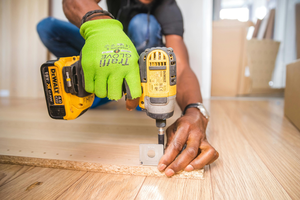

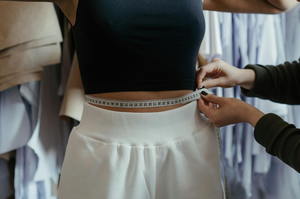

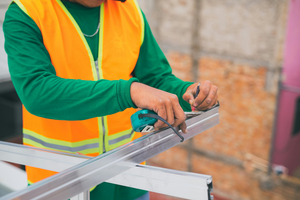

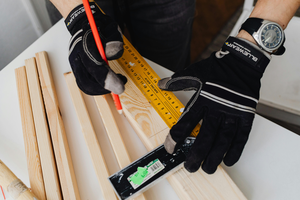

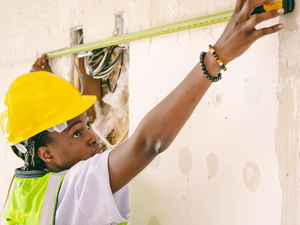

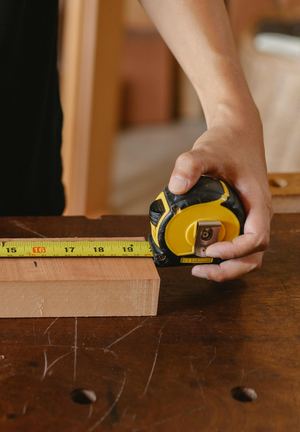

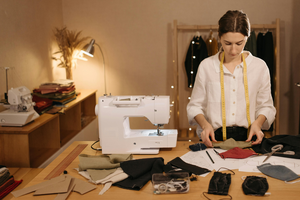

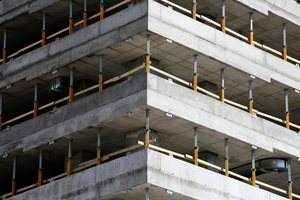

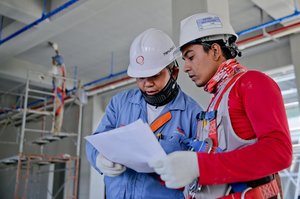

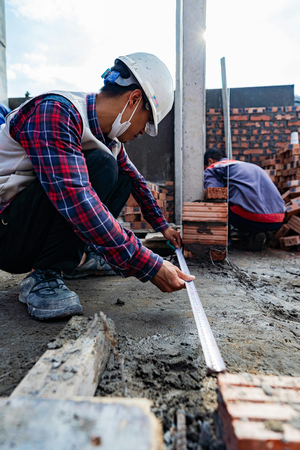

In [3]:
# ============================================================
# CONFIGURATION
# ============================================================

IMAGE_FOLDER = "images"   # Folder containing images
MAX_IMAGES = 10           # Maximum images to load (extended mode)

# ============================================================
# AUTOMATIC IMAGE DETECTION
# ============================================================

# Supported image extensions
SUPPORTED_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

# Find all images in folder
image_files = []
for ext in SUPPORTED_EXTENSIONS:
    image_files.extend(glob.glob(os.path.join(IMAGE_FOLDER, f"*{ext}")))
    image_files.extend(glob.glob(os.path.join(IMAGE_FOLDER, f"*{ext.upper()}")))

# Remove duplicates and sort
image_files = sorted(list(set(image_files)))

# Decide mode based on image count
if len(image_files) == 2:
    # ============================================================
    # ASSIGNMENT MODE: Use 2 SJSU images
    # ============================================================
    IMAGE_URLS = {
        "Science": "https://www.sjsu.edu/_images/people/ADV_college-of-science_2.jpg",
        "Social Sciences": "https://www.sjsu.edu/_images/people/ADV_college-of-social-sciences_2.jpg"
    }
    
    print("\n" + "="*60)
    print("📚 ASSIGNMENT MODE: Using 2 SJSU images")
    print("="*60 + "\n")
    
    # Display the images
    print("Test Images:\n")
    
    print("1. College of Science")
    display(IPImage(filename='images/science.jpg', width=400))
    
    print("\n2. College of Social Sciences")
    display(IPImage(filename='images/social_sciences.jpg', width=400))
    
    print("\n" + "="*60)

else:
    # ============================================================
    # EXTENDED MODE: Use all images from folder
    # ============================================================
    
    # Limit to MAX_IMAGES
    image_files = image_files[:MAX_IMAGES]
    
    print("\n" + "="*60)
    print(f"🔍 EXTENDED MODE: Using {len(image_files)} images from '{IMAGE_FOLDER}/'")
    print(f"   (Limited to {MAX_IMAGES} max)")
    print("="*60 + "\n")
    
    if len(image_files) == 0:
        print(f"⚠️  No images found in '{IMAGE_FOLDER}/'")
        print("Please add images to the folder.")
    else:
        print(f"Found {len(image_files)} images:\n")
        
        # Convert to IMAGE_URLS format using file paths
        IMAGE_URLS = {}
        for img_path in image_files:
            filename = os.path.basename(img_path)
            name = os.path.splitext(filename)[0].replace('_', ' ').title()
            IMAGE_URLS[name] = img_path
            
            size = os.path.getsize(img_path) / 1024  # KB
            print(f"  • {filename} ({size:.1f} KB)")
        
        print("\n" + "="*60)
        print("Image Preview:")
        print("="*60 + "\n")
        
        # Display preview
        for name, img_path in IMAGE_URLS.items():
            try:
                img = Image.open(img_path)
                
                # Resize for preview
                max_width = 300
                if img.width > max_width:
                    ratio = max_width / img.width
                    new_size = (max_width, int(img.height * ratio))
                    img = img.resize(new_size, Image.Resampling.LANCZOS)
                
                display(HTML(f'<p style="font-weight: bold; margin-top: 20px; color: #2c5aa0;">{name}</p>'))
                display(img)
            except Exception as e:
                print(f"Could not display {img_path}: {e}")
        
        print("\n" + "="*60)

### Generate Image Embeddings

Now let's generate embeddings for these images using Cohere's `embed-v4.0` model.

**What's happening here:**
- The model converts each image into a 1,536-dimensional vector
- Each dimension captures different aspects of the image (objects, colors, composition, etc.)
- These vectors represent the "meaning" of the images in numerical form

In [4]:
print("Generating image embeddings...\n")

# Store embeddings by provider
all_embeddings = {provider: {} for provider in PROVIDERS.keys()}

for name, source in IMAGE_URLS.items():
    print(f"Processing {name}...")
    
    # Determine if source is URL or file path
    is_url = source.startswith('http://') or source.startswith('https://')
    
    if is_url:
        # Check if we have a local cached copy first
        cached_path = None
        if name == "Science":
            cached_path = "images/science.jpg"
        elif name == "Social Sciences":
            cached_path = "images/social_sciences.jpg"
        
        # Use cached file if available, otherwise download
        if cached_path and os.path.exists(cached_path):
            try:
                with open(cached_path, 'rb') as f:
                    img_bytes = f.read()
                print(f"  📁 Using cached file: {cached_path}")
            except Exception as e:
                print(f"  ⚠️  Cache read failed, downloading... {e}")
                img_bytes = download_image(source)
        else:
            img_bytes = download_image(source)
            if img_bytes:
                print(f"  🌐 Downloaded from URL")
        
        if img_bytes is None:
            print("  ❌ Failed to get image\n")
            continue
    else:
        # Load from local file
        try:
            with open(source, 'rb') as f:
                img_bytes = f.read()
            print(f"  📁 Loaded from file")
        except Exception as e:
            print(f"  ❌ Failed to load: {e}\n")
            continue
    
    # Generate embeddings with each available provider
    for provider_name, client in PROVIDERS.items():
        try:
            if provider_name == "Cohere":
                # Cohere: Native image support
                base64_img = image_to_base64(img_bytes)
                response = client.embed(
                    model="embed-v4.0",
                    input_type="image",
                    embedding_types=["float"],
                    images=[base64_img]
                )
                all_embeddings[provider_name][name] = response.embeddings.float[0]
                print(f"  ✓ {provider_name}: {len(response.embeddings.float[0])}-dim")
                
            elif provider_name == "OpenAI":
                # OpenAI: Text-only, use URL/filename as proxy
                text_input = source if is_url else os.path.basename(source)
                response = client.embeddings.create(
                    model="text-embedding-3-large",
                    input=text_input,
                    encoding_format="float"
                )
                all_embeddings[provider_name][name] = response.data[0].embedding
                print(f"  ✓ {provider_name}: {len(response.data[0].embedding)}-dim (text proxy)")
                
        except Exception as e:
            print(f"  ❌ {provider_name}: {str(e)[:60]}")
    
    print()

print(f"{'='*60}")
for provider, embeddings in all_embeddings.items():
    print(f"✓ {provider}: {len(embeddings)} image embeddings")
print(f"{'='*60}")

Generating image embeddings...

Processing Pexels-Bidvine-517980-1249611...
  📁 Loaded from file
  ✓ Cohere: 1536-dim
  ✓ OpenAI: 3072-dim (text proxy)

Processing Pexels-Cottonbro-4620607...
  📁 Loaded from file
  ✓ Cohere: 1536-dim
  ✓ OpenAI: 3072-dim (text proxy)

Processing Pexels-Cristian-Rojas-8853473...
  📁 Loaded from file
  ✓ Cohere: 1536-dim
  ✓ OpenAI: 3072-dim (text proxy)

Processing Pexels-Karola-G-7285968...
  📁 Loaded from file
  ✓ Cohere: 1536-dim
  ✓ OpenAI: 3072-dim (text proxy)

Processing Pexels-Kindelmedia-8488026...
  📁 Loaded from file
  ✓ Cohere: 1536-dim
  ✓ OpenAI: 3072-dim (text proxy)

Processing Pexels-Ono-Kosuki-5973895...
  📁 Loaded from file
  ✓ Cohere: 1536-dim
  ✓ OpenAI: 3072-dim (text proxy)

Processing Pexels-Pavel-Danilyuk-6461237...
  📁 Loaded from file
  ✓ Cohere: 1536-dim
  ✓ OpenAI: 3072-dim (text proxy)

Processing Pexels-Pixabay-7931...
  📁 Loaded from file
  ✓ Cohere: 1536-dim
  ✓ OpenAI: 3072-dim (text proxy)

Processing Pexels-Rezwan-121

### Compute Image-to-Image Similarity

Let's measure how similar the two images are to each other using cosine similarity.

In [5]:
print("\n" + "="*60)
print("IMAGE-TO-IMAGE SIMILARITY")
print("="*60)

image_names = list(IMAGE_URLS.keys())

if len(image_names) == 2:
    # Assignment mode: Compare the 2 specific images
    print("\nComparing: Science vs Social Sciences\n")
    
    for provider, embeddings in all_embeddings.items():
        if len(embeddings) >= 2 and "Science" in embeddings and "Social Sciences" in embeddings:
            similarity = cosine_similarity(
                embeddings["Science"],
                embeddings["Social Sciences"]
            )
            print(f"{provider:<15} {similarity:.6f}")
else:
    # Extended mode: Show similarity matrix for all images
    print(f"\nComparing all {len(image_names)} images:\n")
    
    for provider, embeddings in all_embeddings.items():
        if len(embeddings) >= 2:
            print(f"{provider}:")
            print("-" * 60)
            
            # Show pairwise similarities (just first few to avoid clutter)
            pairs_shown = 0
            max_pairs = 5  # Limit output
            
            for i in range(len(image_names)):
                for j in range(i + 1, len(image_names)):
                    if pairs_shown >= max_pairs:
                        print(f"  ... ({len(image_names) * (len(image_names) - 1) // 2 - max_pairs} more pairs)")
                        break
                    
                    img1, img2 = image_names[i], image_names[j]
                    if img1 in embeddings and img2 in embeddings:
                        similarity = cosine_similarity(
                            embeddings[img1],
                            embeddings[img2]
                        )
                        print(f"  {img1[:20]:<20} ↔ {img2[:20]:<20} {similarity:.6f}")
                        pairs_shown += 1
                
                if pairs_shown >= max_pairs:
                    break
            
            print()

print("="*60)


IMAGE-TO-IMAGE SIMILARITY

Comparing all 10 images:

Cohere:
------------------------------------------------------------
  Pexels-Bidvine-51798 ↔ Pexels-Cottonbro-462 0.242157
  Pexels-Bidvine-51798 ↔ Pexels-Cristian-Roja 0.498132
  Pexels-Bidvine-51798 ↔ Pexels-Karola-G-7285 0.581776
  Pexels-Bidvine-51798 ↔ Pexels-Kindelmedia-8 0.525153
  Pexels-Bidvine-51798 ↔ Pexels-Ono-Kosuki-59 0.576137
  ... (40 more pairs)

OpenAI:
------------------------------------------------------------
  Pexels-Bidvine-51798 ↔ Pexels-Cottonbro-462 0.709505
  Pexels-Bidvine-51798 ↔ Pexels-Cristian-Roja 0.698677
  Pexels-Bidvine-51798 ↔ Pexels-Karola-G-7285 0.693531
  Pexels-Bidvine-51798 ↔ Pexels-Kindelmedia-8 0.698579
  Pexels-Bidvine-51798 ↔ Pexels-Ono-Kosuki-59 0.659871
  ... (40 more pairs)



### Generate Text Query Embeddings

Now let's generate embeddings for our text queries. The same model can embed both text and images into the same vector space, enabling cross-modal search!

In [6]:
# Define text queries
text_queries = [
    "person with tape and cap",
    "cart with single tire"
]

print("Generating text query embeddings...\n")

# Store text embeddings by provider
text_embeddings = {provider: {} for provider in PROVIDERS.keys()}

for provider_name, client in PROVIDERS.items():
    try:
        if provider_name == "Cohere":
            response = client.embed(
                model="embed-v4.0",
                input_type="search_query",
                embedding_types=["float"],
                texts=text_queries
            )
            for query, embedding in zip(text_queries, response.embeddings.float):
                text_embeddings[provider_name][query] = embedding
            print(f"✓ {provider_name}: {len(text_queries)} queries embedded")
            
        elif provider_name == "OpenAI":
            for query in text_queries:
                response = client.embeddings.create(
                    model="text-embedding-3-large",
                    input=query,
                    encoding_format="float"
                )
                text_embeddings[provider_name][query] = response.data[0].embedding
            print(f"✓ {provider_name}: {len(text_queries)} queries embedded")
            
    except Exception as e:
        print(f"❌ {provider_name}: {str(e)[:60]}")

print(f"\n{'='*60}")
print("✓ Text embeddings generated")
print(f"{'='*60}")

Generating text query embeddings...

✓ Cohere: 2 queries embedded
✓ OpenAI: 2 queries embedded

✓ Text embeddings generated


### Compute Text-to-Image Similarities

The magic happens here! We can now compare text queries directly with images to find which image best matches each query.

In [7]:
print("\n" + "="*60)
print("TEXT-TO-IMAGE SIMILARITIES")
print("="*60)

results = []
image_names = list(IMAGE_URLS.keys())

# In extended mode with many images, show only top matches per query
# In assignment mode with 2 images, show all comparisons
show_all = len(image_names) <= 3

for query in text_queries:
    print(f"\nQuery: '{query}'")
    print("-" * 60)
    
    # Compute similarities for all images
    query_results = []
    for image_name in image_names:
        for provider_name in PROVIDERS.keys():
            if (query in text_embeddings.get(provider_name, {}) and 
                image_name in all_embeddings.get(provider_name, {})):
                
                similarity = cosine_similarity(
                    text_embeddings[provider_name][query],
                    all_embeddings[provider_name][image_name]
                )
                
                query_results.append({
                    'provider': provider_name,
                    'query': query,
                    'image': image_name,
                    'similarity': similarity
                })
    
    # Add to master results
    results.extend(query_results)
    
    # Display results (all or top 3 per provider)
    if show_all:
        # Show all image comparisons (assignment mode)
        for image_name in image_names:
            print(f"  {image_name}:")
            for provider_name in PROVIDERS.keys():
                matches = [r for r in query_results 
                          if r['image'] == image_name and r['provider'] == provider_name]
                if matches:
                    print(f"    {provider_name:<12} {matches[0]['similarity']:.6f}")
    else:
        # Show top 3 matches per provider (extended mode)
        for provider_name in PROVIDERS.keys():
            provider_results = [r for r in query_results if r['provider'] == provider_name]
            provider_results.sort(key=lambda x: x['similarity'], reverse=True)
            
            print(f"\n  {provider_name} - Top 3 matches:")
            for i, r in enumerate(provider_results[:3], 1):
                print(f"    {i}. {r['image'][:30]:<30} {r['similarity']:.6f}")

print("\n" + "="*60)


TEXT-TO-IMAGE SIMILARITIES

Query: 'person with tape and cap'
------------------------------------------------------------

  Cohere - Top 3 matches:
    1. Pexels-Kindelmedia-8488026     0.226855
    2. Pexels-Thanh-Long-Bui-48314392 0.176687
    3. Pexels-Ono-Kosuki-5973895      0.163408

  OpenAI - Top 3 matches:
    1. Pexels-Cottonbro-4620607       0.248427
    2. Pexels-Bidvine-517980-1249611  0.236779
    3. Pexels-Rezwan-1216589          0.228055

Query: 'cart with single tire'
------------------------------------------------------------

  Cohere - Top 3 matches:
    1. Pexels-Bidvine-517980-1249611  0.107976
    2. Pexels-Karola-G-7285968        0.083087
    3. Pexels-Ono-Kosuki-5973895      0.071004

  OpenAI - Top 3 matches:
    1. Pexels-Karola-G-7285968        0.154424
    2. Pexels-Pixabay-7931            0.148416
    3. Pexels-Cottonbro-4620607       0.131222



### Summary of Results

In [8]:
import pandas as pd

# Create summary table
df = pd.DataFrame(results)

if df.empty:
    print("\n⚠️  No results to display. Please run the text query embedding cell first.")
else:
    print("\n" + "="*60)
    print("SUMMARY: Best Matches by Provider")
    print("="*60)
    
    # Show results based on mode
    image_names = list(IMAGE_URLS.keys())
    
    if len(image_names) == 2:
        # Assignment mode: Show full comparison table
        if len(PROVIDERS) == 1:
            # Single provider: simple table
            provider = list(PROVIDERS.keys())[0]
            pivot_df = df[df['provider'] == provider].pivot(
                index='query', columns='image', values='similarity'
            )
            print(f"\n{provider} Results:")
            print(pivot_df.to_string())
        else:
            # Multiple providers: show comparison
            for provider in PROVIDERS.keys():
                provider_df = df[df['provider'] == provider]
                if not provider_df.empty:
                    pivot_df = provider_df.pivot(
                        index='query', columns='image', values='similarity'
                    )
                    print(f"\n{provider}:")
                    print(pivot_df.to_string())
            
            # Show differences
            if len(PROVIDERS) >= 2:
                print("\n" + "-"*60)
                print("Similarity Score Differences:")
                print("-"*60)
                for query in text_queries:
                    for image in image_names:
                        scores = {}
                        for r in results:
                            if r['query'] == query and r['image'] == image:
                                scores[r['provider']] = r['similarity']
                        
                        if len(scores) >= 2:
                            providers = list(scores.keys())
                            diff = abs(scores[providers[0]] - scores[providers[1]])
                            print(f"\n  {query} → {image}:")
                            for p, s in scores.items():
                                print(f"    {p}: {s:.6f}")
                            print(f"    Difference: {diff:.6f}")
    
    else:
        # Extended mode: Show best match per query per provider
        print()
        for provider in PROVIDERS.keys():
            print(f"\n{provider}:")
            print("-" * 60)
            provider_df = df[df['provider'] == provider]
            
            for query in text_queries:
                query_results = provider_df[provider_df['query'] == query].sort_values(
                    'similarity', ascending=False
                )
                if not query_results.empty:
                    best_match = query_results.iloc[0]
                    print(f"  '{query}'")
                    print(f"    → {best_match['image']} (score: {best_match['similarity']:.4f})")
    
    print("\n" + "="*60)


SUMMARY: Best Matches by Provider


Cohere:
------------------------------------------------------------
  'person with tape and cap'
    → Pexels-Kindelmedia-8488026 (score: 0.2269)
  'cart with single tire'
    → Pexels-Bidvine-517980-1249611 (score: 0.1080)

OpenAI:
------------------------------------------------------------
  'person with tape and cap'
    → Pexels-Cottonbro-4620607 (score: 0.2484)
  'cart with single tire'
    → Pexels-Karola-G-7285968 (score: 0.1544)



---

## Interactive Image Search

Now you can search through your images using **any text query** and get ranked results!

The embeddings are already generated, so searching is instant.

### Search Function Setup

In [9]:
# Use first available provider for interactive search
primary_provider = list(PROVIDERS.keys())[0]
primary_client = PROVIDERS[primary_provider]

print(f"✓ Using {primary_provider} for interactive search")
print(f"✓ {len(all_embeddings.get(primary_provider, {}))} images ready to search")

✓ Using Cohere for interactive search
✓ 10 images ready to search


### Define Search Function

In [10]:
def search_images(query, top_k=5):
    """Search images with a text query and display ranked results."""
    print(f"\n{'='*60}")
    print(f"Searching for: '{query}'")
    print(f"{'='*60}\n")
    
    # Generate query embedding using primary provider
    if primary_provider == "Cohere":
        response = primary_client.embed(
            model="embed-v4.0",
            input_type="search_query",
            embedding_types=["float"],
            texts=[query]
        )
        query_embedding = response.embeddings.float[0]
        
    elif primary_provider == "OpenAI":
        response = primary_client.embeddings.create(
            model="text-embedding-3-large",
            input=query,
            encoding_format="float"
        )
        query_embedding = response.data[0].embedding
    
    # Get embeddings for this provider
    provider_embeddings = all_embeddings.get(primary_provider, {})
    
    # Compute similarities
    similarities = []
    for img_name, img_embedding in provider_embeddings.items():
        similarity = cosine_similarity(query_embedding, img_embedding)
        similarities.append((img_name, similarity))
    
    # Sort by similarity (highest first)
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Display results
    print(f"Top {min(top_k, len(similarities))} Results:\n")
    
    for rank, (img_name, score) in enumerate(similarities[:top_k], 1):
        # Display result card
        display(HTML(f"""
            <div style="margin-bottom: 30px; padding: 15px; border: 2px solid #2c5aa0; 
                        border-radius: 10px; background: #f0f7ff;">
                <h3 style="margin-top: 0; color: #2c5aa0;">#{rank} - {img_name}</h3>
                <p style="font-size: 18px; color: #333; margin: 10px 0;">
                    <strong>Similarity Score: {score:.6f}</strong>
                </p>
            </div>
        """))
        
        # Get image source
        img_source = IMAGE_URLS[img_name]
        
        try:
            # Determine if it's a URL or file path
            if img_source.startswith('http://') or img_source.startswith('https://'):
                # For URLs, use local cached file
                if img_name == "Science":
                    img_path = "images/science.jpg"
                elif img_name == "Social Sciences":
                    img_path = "images/social_sciences.jpg"
                else:
                    img_path = img_source
            else:
                # Already a file path
                img_path = img_source
            
            # Load and display image
            img = Image.open(img_path)
            max_width = 500
            if img.width > max_width:
                ratio = max_width / img.width
                new_size = (max_width, int(img.height * ratio))
                img = img.resize(new_size, Image.Resampling.LANCZOS)
            display(img)
                
        except Exception as e:
            print(f"  Could not display image: {e}")

print("✓ Search function ready")
print("\nTry searching:")
print("  search_images('person with tape and cap', top_k=3)")
print("  search_images('your custom query', top_k=5)")

✓ Search function ready

Try searching:
  search_images('person with tape and cap', top_k=3)
  search_images('your custom query', top_k=5)



Searching for: 'person with tape and cap'

Top 3 Results:



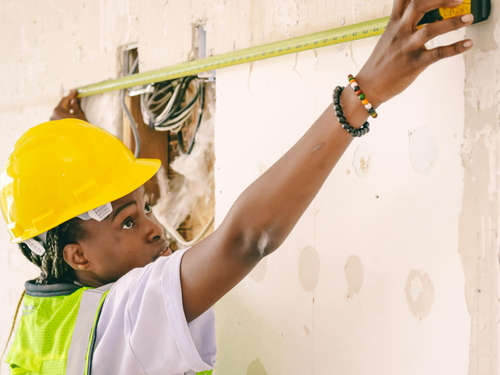

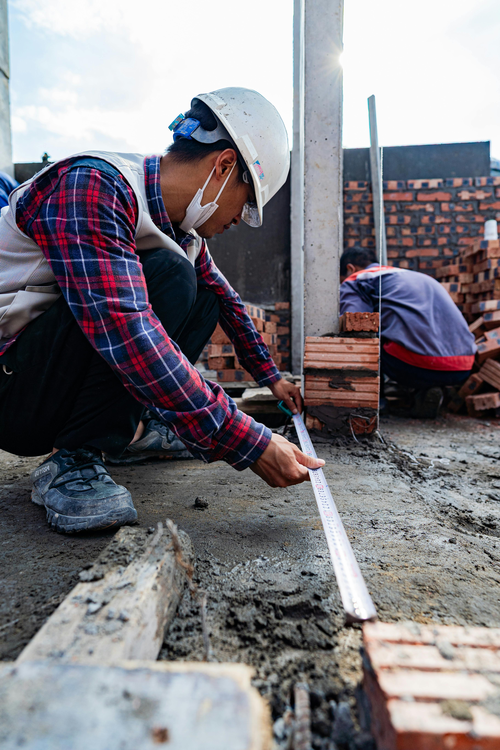

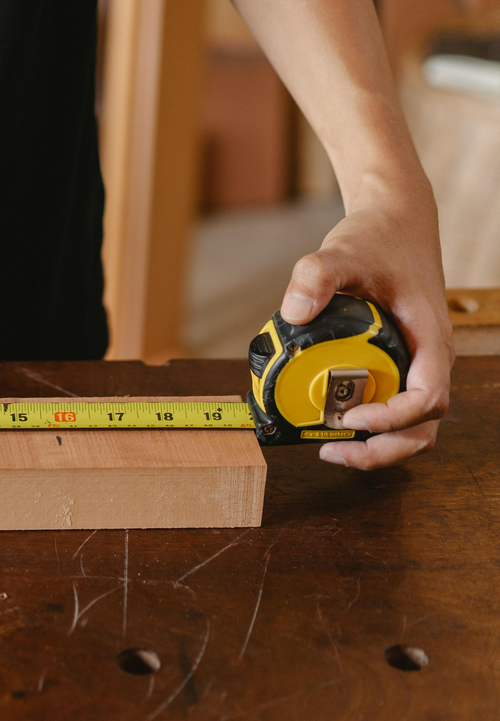

In [11]:
# Search with your query (edit the text below)
search_images("person with tape and cap", top_k=3)

# Try other queries:
# search_images("person sitting", top_k=5)
# search_images("outdoor scene", top_k=3)
# search_images("technology", top_k=5)

### Try Different Searches!

Edit the query in the cell below and run it to search with different terms.

---

Each image and text query is converted to a high-dimensional vector (1,536 dimensions for Cohere, 3,072 for OpenAI). Similar concepts are placed close together in this space. Cosine similarity measures the angle between vectors - a smaller angle means more similar content. Multimodal models like Cohere's `embed-v4.0` embed both images and text into the same space, enabling cross-modal search.

The similarity scores range from -1 to 1, where higher scores indicate stronger matches. Scores above 0.8 show excellent matches, 0.6-0.8 are good matches, 0.4-0.6 are moderate, 0.2-0.4 are weak, and below 0.2 are poor matches.

Cohere's `embed-v4.0` is a multimodal model trained on millions of image-text pairs. It learned to recognize objects, scenes, people, and actions, understand relationships between visual and textual concepts, and map both modalities into a unified semantic space. This enables finding images using natural language.

When comparing providers, Cohere has native image support and can actually "see" the image content, while OpenAI's text-only model uses URLs or filenames as a proxy, which is less accurate for visual search.

Embeddings enable many practical applications beyond search - clustering similar content, automatic classification, content recommendation, duplicate detection, and content moderation all use the same underlying technology.

---

**Image Attribution:** Sample images provided by talented photographers on [Pexels.com](https://www.pexels.com). All images are free to use under the Pexels License.

---

---

Embeddings represent meaning as numbers, enabling mathematical comparisons between different types of content. Cosine similarity provides a simple way to measure relevance - the higher the score, the more similar the concepts. Multimodal models bridge the gap between text and images by placing them in the same semantic space, making cross-modal search possible.

These techniques have practical applications everywhere - search engines, content recommendation systems, automated classification, image clustering, duplicate detection, and content moderation all rely on embeddings to understand and compare content at scale.

Try experimenting with different query phrasings to see what works best. You can add more images to your folder and re-run the notebook to see how well it scales. For production applications, consider building a web interface with Streamlit or Gradio, or scale to thousands of images using vector databases like Pinecone or Weaviate.

**Resources:**
- [Cohere Embed v4.0 Documentation](https://docs.cohere.com/docs/embed-v4)
- [Image Embeddings Guide](https://docs.cohere.com/v2/docs/embeddings#image-embeddings)
- [Get Free API Key](https://dashboard.cohere.com/api-keys)
- [Vector Search Tutorial](https://docs.cohere.com/docs/semantic-search)